<a href="https://colab.research.google.com/github/GeorgiosTheocharidis/intelligent_agents_lstm/blob/main/Designing_Intelligent_Agents_LSTM_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns

In [2]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [6]:
train=files.upload()

Saving train.csv to train (1).csv


In [ ]:
subm=files.upload()

Saving sample_submission.csv to sample_submission.csv


In [7]:

test=files.upload()

Saving test.csv to test.csv


In [5]:
df_train=pd.concat(pd.read_csv(p) for p in train)
print(df_train)
df_test=pd.concat(pd.read_csv(p) for p in test)
print(df_test)
df_train.head()


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


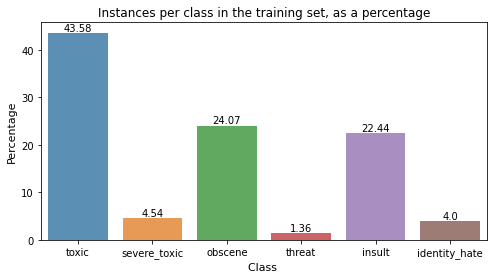

In [ ]:
#Making the plot
plt_values=df_train.iloc[:,2:].sum()
plt_sum=x=plt_values.sum()
plt_values=plt_values/plt_sum
plt_values*=100
plt_values=round(plt_values,2)
plt.figure(figsize=(8,4))
plt.title("Instances per class in the training set, as a percentage")
plt.xlabel('Class ', fontsize=11)
plt.ylabel('Percentage', fontsize=11)
occurances_plt= sns.barplot(plt_values.index, plt_values.values, alpha=0.8)
rects = occurances_plt.patches
labels = plt_values.values
for rect, label in zip(rects, labels):
    bar_height = rect.get_height()
    occurances_plt.text(rect.get_x() + rect.get_width()/2, bar_height , label, ha='center', va='bottom')

plt.show()

This means that the rest of the comments are clean, meaning 140k are not toxic. This creates an imbalance in the classes.

In [ ]:
max_features = 25000
maxlen = 150

In [ ]:
train_list = df_train["comment_text"].fillna(" ").values
test_list = df_test["comment_text"].fillna(" ").values
classes_title = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df_train.head()
y = df_train[classes_title].values


In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_list))
list_tokenized_train = tokenizer.texts_to_sequences(train_list)
list_tokenized_test = tokenizer.texts_to_sequences(test_list)
X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
def get_model():
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
#Testing random weights
model = get_model()
batch_size = 64
epochs = 1
file_path="toxic_comments_weights.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [ ]:
callbacks_list = [checkpoint, early] #early
model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)

model.load_weights(file_path)

y_test = model.predict(X_test)

2244/2244 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9520
Epoch 1: val_loss improved from inf to 0.04973, saving model to toxic_comments_weights.best.hdf5
2244/2244 [==============================] - 550s 243ms/step - loss: 0.0673 - accuracy: 0.9520 - val_loss: 0.0497 - val_accuracy: 0.9940


In [ ]:
df_subm=pd.concat(pd.read_csv(p) for p in subm)
print(df_subm)

                      id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12    0.5           0.5      0.5     0.5     0.5   
1       0000247867823ef7    0.5           0.5      0.5     0.5     0.5   
2       00013b17ad220c46    0.5           0.5      0.5     0.5     0.5   
3       00017563c3f7919a    0.5           0.5      0.5     0.5     0.5   
4       00017695ad8997eb    0.5           0.5      0.5     0.5     0.5   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5    0.5           0.5      0.5     0.5     0.5   
153160  fffd7a9a6eb32c16    0.5           0.5      0.5     0.5     0.5   
153161  fffda9e8d6fafa9e    0.5           0.5      0.5     0.5     0.5   
153162  fffe8f1340a79fc2    0.5           0.5      0.5     0.5     0.5   
153163  ffffce3fb183ee80    0.5           0.5      0.5     0.5     0.5   

        identity_hate  
0                 0.5  
1                 0.5  
2                 0.5  
3              

In [ ]:
df_subm[classes_title] = y_test
print(df_subm)

                      id     toxic  severe_toxic   obscene    threat  \
0       00001cee341fdb12  0.986173  1.999568e-01  0.917176  0.042189   
1       0000247867823ef7  0.001084  1.228026e-06  0.000160  0.000006   
2       00013b17ad220c46  0.006209  1.623345e-05  0.000908  0.000085   
3       00017563c3f7919a  0.001014  8.273016e-07  0.000157  0.000004   
4       00017695ad8997eb  0.013196  3.138380e-05  0.001899  0.000165   
...                  ...       ...           ...       ...       ...   
153159  fffcd0960ee309b5  0.586550  3.002822e-03  0.134201  0.009147   
153160  fffd7a9a6eb32c16  0.007521  1.070609e-05  0.001041  0.000059   
153161  fffda9e8d6fafa9e  0.001107  9.552217e-07  0.000170  0.000005   
153162  fffe8f1340a79fc2  0.003528  4.487197e-06  0.000543  0.000022   
153163  ffffce3fb183ee80  0.926175  4.305038e-02  0.621595  0.029644   

          insult  identity_hate  
0       0.781377       0.149099  
1       0.000112       0.000034  
2       0.000850       0.000275  

In [ ]:
df_subm
df_subm.to_csv("baseline.csv", index=False)

In [ ]:
max_val_dict={}
inst_dict={}
inst_count=0
for i in df_subm[classes_title]:
  for z in df_subm[classes_title][i]:
      if z>0.3:
        inst_count+=1
  inst_dict[i] = inst_count
  max_value = df_subm[classes_title][i].max()
  max_val_dict[i] = max_value
  inst_count=0

maximum_pred=pd.DataFrame.from_dict(max_val_dict, orient='index')
print("Higest predicted value per class.",maximum_pred)

#Making the frequency plot for the predictions 
instances_plt=pd.DataFrame.from_dict(inst_dict, orient='index')
plt_values=instances_plt[0]
plt_sum=x=plt_values.sum()
plt_values=plt_values/plt_sum
plt_values*=100
plt_values=round(plt_values,2)
plt.figure(figsize=(8,4))
plt.title("Model's predicted instances per class, as a percentage")
plt.xlabel('Class ', fontsize=11)
plt.ylabel('Percentage', fontsize=11)
occurances_plt= sns.barplot(plt_values.index, plt_values.values, alpha=0.8)
rects = occurances_plt.patches
labels = plt_values.values
for rect, label in zip(rects, labels):
    bar_height = rect.get_height()
    occurances_plt.text(rect.get_x() + rect.get_width()/2, bar_height , label, ha='center', va='bottom')

plt.show()

